This is a notebook on Reinforcement Learning, with implementations of Q learning and deep Q learning ( both using DIY neural network and keras).
It can work on multiple environments with tuning: Cartpole, Acrobot, MountainCar, FrozenLake...

I left the code for other RL agents but the only one executed here is the Deep Q learning agent using keras on Cartpole.

Reference: https://keon.io/deep-q-learning/

In [1]:
import random
import numpy as np
import time

import gym #Using OpenAI Gym
from gym.envs.registration import register
from IPython.display import clear_output

#Fast double ended queue
from collections import deque 

#Trying my own implementation of NNs
from neuralnetwork import * 

# Keras for Deep Q learning (more efficient than DIY of course...)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

random.seed(42)

Using TensorFlow backend.


In [2]:
### Options for environment (different games)
# env_name = "CartPole-v1"
# env_name = "Acrobot-v1"
# env_name = "MountainCar-v0"
# env_name = "MountainCarContinuous-v0"
# try:
#     register(
#         id='FrozenLakeNoSlip-v0',
#         entry_point='gym.envs.toy_text:FrozenLakeEnv',
#         kwargs={'map_name' : '4x4', 'is_slippery':False},
#         max_episode_steps=100,
#         reward_threshold=0.78, # optimum = .8196
#     )
# except:
#     pass
#env_name = "FrozenLake-v0"
#env_name = "FrozenLakeNoSlip-v0"

###Cartpole but with longer experiment
try: register(
    id='CartPole-v2',
    entry_point='gym.envs.classic_control:CartPoleEnv',
    tags={'wrapper_config.TimeLimit.max_episode_steps': 500},
    reward_threshold=1475.0,
)
except:
    pass
env_name = "CartPole-v2"


env = gym.make(env_name)

In [3]:
env.observation_space

Box(4,)

In [4]:
class Agent():
    def __init__(self,env):
        self.is_discrete = type(env.action_space)==gym.spaces.discrete.Discrete
        if self.is_discrete:
            self.action_size = env.action_space.n
            print("Action size:", self.action_size)
        else:
            self.action_low = env.action_space.low
            self.action_high = env.action_space.high
            self.action_shape = env.action_space.shape
            print("Action range:", self.action_low, self.action_high)
            
    def get_random_action(self,state):
        if self.is_discrete:
            action = random.choice(range(self.action_size))
        else:
            action = np.random.uniform(self.action_low, \
                                       self.action_high, self.action_shape)

        return action

In [5]:
class QAgent(Agent):
    def __init__(self,env, discount_rate =0.97, learning_rate=0.01):
        super().__init__(env)
        self.state_size = env.observation_space.shape[0]
        print("State size:", self.state_size)
        self.eps =1.0 #epsilon greedy
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.build_model()

    def build_model(self):
        self.q_table = 1e-4*np.random.random([self.state_size, self.action_size]) 
        #States are rows and actions are columns
    
    def get_action(self,state):
        q_state= self.q_table[state]
        action_greedy = np.argmax(q_state)
        action_random = super().get_random_action(state)
        return action_random if random.random() < self.eps else action_greedy
    
    def train(self, experience):
        state, action, next_state, reward, done = experience
        q_next = self.q_table[next_state]
        q_next = np.zeros([self.action_size]) if done else q_next
        q_target = reward + self.discount_rate * np.max(q_next)
        q_update = q_target - self.q_table[state,action]
        self.q_table[state,action] += self.learning_rate*q_update
        #new_q = old_q + learning_rate*(learned value - old_q)
        if done:
            self.eps = self.eps*0.99
agent = QAgent(env)

Action size: 2
State size: 4


Epsilon Q learning:

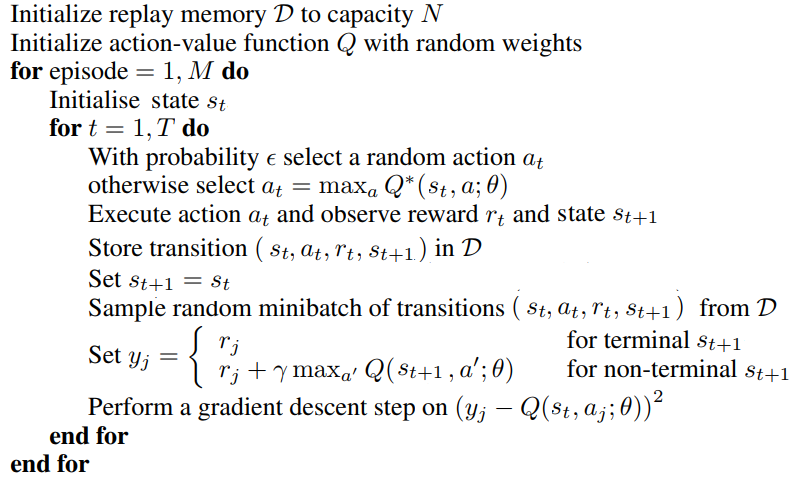

In [6]:
class DIYDQAgent(Agent):
    def __init__(self, env, discount_rate = 0.99, learning_rate=0.01):
        super().__init__(env)
        self.state_size = env.observation_space.shape[0]
        print("State sze:", self.state_size)
        self.eps =1.0 #epsilon greedy
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.build_model()
    
    #The q network should be able to take a state and 
    #output the estimated q value of all actions you can take in said state
    def build_model(self):
        x=np.zeros((1,self.state_size))
        y=np.zeros((1,self.action_size))
        layers_size=np.array([20,20])
        self.q_network = NeuralNetwork(x,y,layers_size)
        self.D_storage = []
        self.len_D = 0
        self.D_capacity= 20
        self.eps_decay =0.995
        
    def get_action(self,state):
        #SV = np.zeros((1,self.state_size))
        #SV[0,state]=1
        SV= state
        q_state= self.q_network.output(SV)
        action_greedy = np.argmax(q_state)
        action_random = super().get_random_action(state)
        return action_random if random.random() < self.eps else action_greedy
    
    def train(self, experience, minibatch_size = 5):
        state, action, next_state, reward, done = experience
        if done:
            self.eps = self.eps*self.eps_decay
        self.D_storage += [experience]
        self.len_D +=1
        if self.len_D > self.D_capacity:
            self.D_storage = self.D_storage[-self.D_capacity:]
            self.len_D = len(self.D_storage)
        len_random_batch = np.min((minibatch_size,self.len_D))
        random_batch = random.sample(range(self.len_D),len_random_batch)
        x= np.zeros((len_random_batch,self.state_size))
        y= np.zeros((len_random_batch,self.action_size))
        for k in range(len_random_batch):
            state, action, next_state, reward, done = self.D_storage[random_batch[k]]
            reward = reward
            #SV = np.zeros((1,self.state_size))
            #SV[0,state]=1
            #x[k]=SV
            x[k]=state
            #SNextV=np.zeros((1,self.state_size))
            #SNextV[0,next_state]=1
            SNextV= next_state
            q_next = self.q_network.output(SNextV)
            q_next = np.zeros([self.action_size]) if done else q_next
            q_target = reward + self.discount_rate * np.max(q_next)
            y[k]= self.q_network.output(x[k])
            y[k,action] = q_target 
        self.q_network.training_inputs = x
        self.q_network.training_batch_size = len_random_batch
        self.q_network.training_outputs = y
        self.q_network.train(20,lr=1,method='batch')
    


Same idea but with keras

In [7]:
class KDQNAgent(Agent):
    def __init__(self, env, discount_rate = 0.95, learning_rate=0.001):
        super().__init__(env)
        self.state_size = env.observation_space.shape[0]
        
        self.eps =1.0 #epsilon greedy
        self.eps_decay =0.995
        
        self.discount_rate = discount_rate
        self.learning_rate = learning_rate
        self.build_model()

        self.D_capacity= 2000
        self.D_storage = deque(maxlen=self.D_capacity)

        
    #The q network should be able to take a state and 
    #output the expected q value of all possible actions in said state
    def build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu' ))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        self.model = model
        
    
    def remember(self,state,action,reward,next_state,done):
        self.D_storage.append((state,action,reward,next_state,done))
        
    def get_action(self,state):
        q_state= self.model.predict(state)[0]
        action_greedy = np.argmax(q_state)
        action_random = super().get_random_action(state)
        return action_random if np.random.rand() < self.eps else action_greedy
    
    def train(self, minibatch_size = 32):

        random_batch = random.sample(self.D_storage,minibatch_size)

        for state, action, next_state, reward, done in random_batch:

            q_next = self.model.predict(next_state)[0]
            q_next = np.zeros([self.action_size]) if done else q_next
            q_target = reward + self.discount_rate * np.amax(q_next)
            
            y= self.model.predict(state)
            y[0,action] = q_target 
            self.model.fit(state, y, epochs= 1, verbose=0)

        if self.eps > 0.01:
            self.eps = self.eps*self.eps_decay
        
    def load(self,name):
        self.model.load_weights(name)
    def save(self,name):
        self.model.save_weights(name)
    

Defining our agent a training it

In [8]:
### Keras Deep Q Neural Network
agent = KDQNAgent(env)

### DIY Neural Network alternative
# agent = DIYDQAgent(env)

state_size=4

Action size: 2


In [9]:

#agent = Agent(env)
for ep in range(1000):
    i = 0
    state = env.reset()    #Resets the game
    state = np.reshape(state, [1,state_size])     #Proper dimensions
    done = False     #variable descripting if the game is over or not
    while not(done):
        i+=1             #One more step in the game
        #action = env.action_space.sample()    # This is for a totally random agent
        action = agent.get_action(state)    #Let the agent decide which action to take in this state
        next_state, reward, done, info = env.step(action) #Take a step using this action
        reward = reward if not done else -25  #If we are not done: reward, else penalize
        next_state = np.reshape(next_state, [1,state_size])  #Next state for the loop
        agent.remember(state,action,next_state,reward,done) #Tells our agent to remember to learn from what happened
        state = next_state    
        
#         ### Renders every 50 game episodes 
#         if ep % 50 ==0:
#             env.render()
        
        ### When the episode is done, print episode number /1000 and total number of steps
        if done:
            print(ep,'/',1000,'lifetime=',i)
        
        ###Stopping the episode after 2000 steps 
        ###(the AI is getting too good and I like my while loops to stop)
        if (i>2000):
            done = True
            
    ###When the episode is done, train our agent when we have enough samples (64)
    if len(agent.D_storage)>32:
        agent.train()


0 / 1000 lifetime= 11
1 / 1000 lifetime= 12
2 / 1000 lifetime= 21
3 / 1000 lifetime= 41
4 / 1000 lifetime= 20
5 / 1000 lifetime= 64
6 / 1000 lifetime= 45
7 / 1000 lifetime= 29
8 / 1000 lifetime= 11
9 / 1000 lifetime= 15
10 / 1000 lifetime= 11
11 / 1000 lifetime= 40
12 / 1000 lifetime= 24
13 / 1000 lifetime= 25
14 / 1000 lifetime= 13
15 / 1000 lifetime= 12
16 / 1000 lifetime= 12
17 / 1000 lifetime= 10
18 / 1000 lifetime= 48
19 / 1000 lifetime= 11
20 / 1000 lifetime= 34
21 / 1000 lifetime= 26
22 / 1000 lifetime= 14
23 / 1000 lifetime= 11
24 / 1000 lifetime= 11
25 / 1000 lifetime= 24
26 / 1000 lifetime= 30
27 / 1000 lifetime= 19
28 / 1000 lifetime= 28
29 / 1000 lifetime= 49
30 / 1000 lifetime= 38
31 / 1000 lifetime= 12
32 / 1000 lifetime= 16
33 / 1000 lifetime= 14
34 / 1000 lifetime= 14
35 / 1000 lifetime= 16
36 / 1000 lifetime= 29
37 / 1000 lifetime= 14
38 / 1000 lifetime= 13
39 / 1000 lifetime= 23
40 / 1000 lifetime= 13
41 / 1000 lifetime= 24
42 / 1000 lifetime= 14
43 / 1000 lifetime= 2

347 / 1000 lifetime= 73
348 / 1000 lifetime= 151
349 / 1000 lifetime= 93
350 / 1000 lifetime= 131
351 / 1000 lifetime= 155
352 / 1000 lifetime= 120
353 / 1000 lifetime= 93
354 / 1000 lifetime= 125
355 / 1000 lifetime= 123
356 / 1000 lifetime= 121
357 / 1000 lifetime= 113
358 / 1000 lifetime= 90
359 / 1000 lifetime= 134
360 / 1000 lifetime= 141
361 / 1000 lifetime= 195
362 / 1000 lifetime= 86
363 / 1000 lifetime= 110
364 / 1000 lifetime= 87
365 / 1000 lifetime= 74
366 / 1000 lifetime= 94
367 / 1000 lifetime= 82
368 / 1000 lifetime= 95
369 / 1000 lifetime= 46
370 / 1000 lifetime= 16
371 / 1000 lifetime= 54
372 / 1000 lifetime= 140
373 / 1000 lifetime= 58
374 / 1000 lifetime= 53
375 / 1000 lifetime= 73
376 / 1000 lifetime= 109
377 / 1000 lifetime= 120
378 / 1000 lifetime= 78
379 / 1000 lifetime= 60
380 / 1000 lifetime= 16
381 / 1000 lifetime= 16
382 / 1000 lifetime= 13
383 / 1000 lifetime= 12
384 / 1000 lifetime= 13
385 / 1000 lifetime= 15
386 / 1000 lifetime= 17
387 / 1000 lifetime= 43
3

678 / 1000 lifetime= 228
679 / 1000 lifetime= 179
680 / 1000 lifetime= 260
681 / 1000 lifetime= 199
682 / 1000 lifetime= 194
683 / 1000 lifetime= 167
684 / 1000 lifetime= 169
685 / 1000 lifetime= 159
686 / 1000 lifetime= 166
687 / 1000 lifetime= 148
688 / 1000 lifetime= 144
689 / 1000 lifetime= 153
690 / 1000 lifetime= 117
691 / 1000 lifetime= 131
692 / 1000 lifetime= 174
693 / 1000 lifetime= 208
694 / 1000 lifetime= 269
695 / 1000 lifetime= 466
696 / 1000 lifetime= 148
697 / 1000 lifetime= 147
698 / 1000 lifetime= 165
699 / 1000 lifetime= 175
700 / 1000 lifetime= 200
701 / 1000 lifetime= 217
702 / 1000 lifetime= 188
703 / 1000 lifetime= 173
704 / 1000 lifetime= 167
705 / 1000 lifetime= 194
706 / 1000 lifetime= 234
707 / 1000 lifetime= 141
708 / 1000 lifetime= 130
709 / 1000 lifetime= 161
710 / 1000 lifetime= 162
711 / 1000 lifetime= 132
712 / 1000 lifetime= 179
713 / 1000 lifetime= 170
714 / 1000 lifetime= 175
715 / 1000 lifetime= 160
716 / 1000 lifetime= 180
717 / 1000 lifetime= 174


In [10]:
# 10 more games now that the training is over
agent.eps = 0 

for x in range(10):
    i = 0
    state = env.reset()    #Resets the game
    state = np.reshape(state, [1,state_size])     #Proper dimensions
    done = False     #variable descripting if the game is over or not
    while not(done):
        i+=1             #One more step in the game
        action = agent.get_action(state)    #Let the agent decide which action to take in this state
        next_state, reward, done, info = env.step(action) #Take a step using this action
        reward = reward if not done else -10  #If we are not done: reward, else penalize
        next_state = np.reshape(next_state, [1,state_size])  #Next state for the loop
        agent.remember(state,action,next_state,reward,done) #Tells our agent to remember to learn from what happened
        state = next_state    

        env.render()
        if done:
            print('lifetime=',i)


lifetime= 322
lifetime= 337
lifetime= 335
lifetime= 358
lifetime= 308
lifetime= 367
lifetime= 356
lifetime= 320
lifetime= 346
lifetime= 318


Deep Q learning this way seems to be very finicky, had sometimes amazing results and sometimes very poor ones...